In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model): # i는 위치
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angles_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], 
                                      i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], 
                                      d_model=d_model)
        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angles_rads[:, 0::2])  # 짝수만 적용
        cosines = tf.math.cos(angles_rads[:, 1::2]) # 홀수만 적용
        
        print("angle rads shape: ", angles_rads.shape)
        angles_rads = np.zeros(angles_rads.shape)
        angles_rads[:, 0::2] = sines
        angles_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angles_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        print("positional encoding shape: ", pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query 문장길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key 문장길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value 문장길이, d_model/num_heads)
    # padding mask : (batch_size, 1, 1, key의 문장길이)
    
    # Q와 K의 곱. 어텐션 스코어의 행렬
    matmul_qk = tf.matmul(query, key, transpose_b=True) # key를 전치한 후 곱함
    
    # 스케일링 : dk의 루트값으로 나눔
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 마스킹. 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣는다.
    # 아주 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 됨
    if mask is not None:
        logits += (mask * -1e9)
        
    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행됨
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # output : (batch_size, num_heads, query 문장길이, d_mode/num_heads)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        # d_model을 num_heads로 나눈 값(d_k)
        self.depth = d_model // self.num_heads
        
        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        # W0에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    # num_heads 만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q: (batch_size, query의 문장길이, d_model)
        # k: (batch_size, key의 문장길이, d_model)
        # v: (batch_size, value의 문장길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있음
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 3. scaled dot product attention (앞서 구현한 함수 이용)
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        
        # (batch_size, query 문장길이, num_heads, d_model/num_hedas)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 4. 헤드 연결
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # 5. W0에 해당하는 밀집층 지나기
        # (batch_size, query 문장 길이, d_model)
        outputs = self.dense(concat_attention)  # self.dense == WO
        
        return outputs

In [6]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)  # x=0이면 True이므로 1반환
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
def encoder_layer(dff, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name='attention')({
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': padding_mask,
    })
    
    # dropout ==> 잔차연결, 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # 포지션 와이드 FNN(두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 드롭아웃 ==> 잔차연결, 층정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs) # 여기서는 attention을 더함
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [8]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None, ), name="inputs")
    
    # 인코더는 패딩 마스크를 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, 
                                name='encoder_layer_{}'.format(i))([outputs, padding_mask])
    print(outputs)
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [9]:
# 디코더의 첫번째 서브층에서 미래 토른을 mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # 상삼각행렬 구하기
    padding_mask = create_padding_mask(x) # 패딩 마스크도 추가
    #print(look_ahead_mask)
    #print(padding_mask)
    return tf.maximum(look_ahead_mask, padding_mask)

In [10]:
def decoder_layer(dff, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name='attention1')(inputs={
        'query': inputs, 'key': inputs, 'value': inputs,  # Q = K = V
        'mask': look_ahead_mask
    })
    
    # 잔차연결과 층 정규화(드롭아웃 생략)
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 멀티 헤드 어텐션(두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask
    })
    
    # 드롭아웃 + 잔차연결, 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 포지션 와이드 FNN(세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 드롭아웃 + 잔차연결, 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [11]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='enc_outputs')
    
    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘다 사용
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 디코더를 num_layer개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, 
                                name='decoder_layer_{}'.format(i))\
        (inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name
    )

In [12]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):
    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    
    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    
    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs) # 주의!!
    
    # 인코더의 출력은 enc_outputs 디코더로 전달
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, 
                          num_heads=num_heads, d_model=d_model, dropout=dropout)\
                        (inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력문장과 패딩 마스크
    
    # 디코더의 출력은 dec_outputs, 출력층으로 전달
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, 
                          d_model=d_model, num_heads=num_heads, dropout=dropout)\
                        (inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

angle rads shape:  (9000, 128)
positional encoding shape:  (1, 9000, 128)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

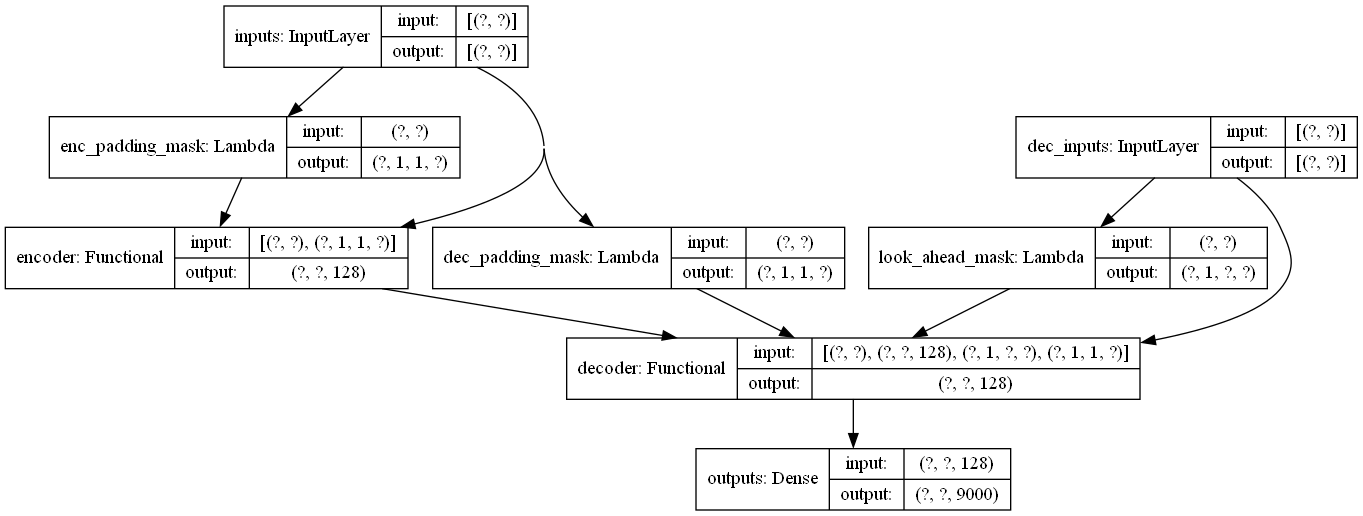

In [13]:
# 논문과 다르게 설정
small_transformer = transformer(
    vocab_size=9000, num_layers=4, dff=512, d_model=128, num_heads=4, 
    dropout=0.3, name='small_transformer')

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True
)

### 19. 손실함수 정의
--------------------
다중 클래스 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실함수로 정의

In [14]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

### 20. 학습률
----------------
학습률 스케줄러는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법임. 트랜스포머의 경우 **사용자가 정한 단계까지 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식**을 사용함

1 step_num(단계)는 옵티마이저가 매개변수 업데이트를 한번 진행한다는 작업을 의미하고, warmup_steps라는 변수를 정하여 step_num이 warmup_steps보다 작을 경우 학습률을 선형적으로 증가시키고, 도달할 경우에 step_num의 역제곱근에 따라 감소시킴

$$\Large{lrate = d_{model}^{-0.5} × min(\text{step_num}^{-0.5},\ \text{step_num} × \text{warmup_steps}^{-1.5})}$$

여기에서는 warmup_steps 값으로 4,000을 사용함

In [15]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## 트랜스포머를 이용한 한국어 챗봇

### 1. 데이터 로드

In [16]:
import pandas as pd
import numpy as np
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [17]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", 
                           filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


질문과 대답의 쌍을 이룬 데이터임

In [18]:
print(train_data.shape)

(11823, 3)


### 2. 전처리

In [19]:
# Null 값 확인 ==> 없음
train_data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

토큰화를 위해 형태소 분석기를 사용하지 않고, 학습기반의 토크나이저 사용. 먼저, 구두점 등의 부호를 미리 처리하나 여기에서는 제거하지 않고 공백으로 대체하여 다른 문자들과 구분함

In [20]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r'([?.!,])', r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [21]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r'([?.!,])', r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [22]:
print(questions[:5])
print('-'*50)
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
--------------------------------------------------
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


### 3. 단어 집합 생성
-------------------
서브워드 텍스트 인코더를 사용하여 토큰 분리. 자주 사용되는 서브워드 단위로 토큰을 분리하는 토크나이저로 학습데이터로부터 학습하여 서브워드로 구성된 단어집합을 생성함

In [23]:
# 서브워드 텍스트 인코더를 사용하여 질문, 답변 데이터로부터 단어집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

단어집합이 생성되었지만, 여기에 시작과 끝을 의미하는 토큰 \<SOS>와 \<EOS>를 포함해야 하므로 이 토큰에 정수를 부여해 줌 

In [24]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

VOCAB_SIZE = tokenizer.vocab_size + 2

In [25]:
print('시작토큰 번호:', START_TOKEN)
print('끝 토큰 번호:', END_TOKEN)
print('단어집합 크기 :', VOCAB_SIZE)

시작토큰 번호: [8178]
끝 토큰 번호: [8179]
단어집합 크기 : 8180


### 4. 정수 인코딩과 패딩
---------------------------
단어 집합을 생성한 후에 토큰나이저로 정수인코딩 실행. .encode()로 가능

In [26]:
# example
tokenizer.encode(questions[20])

[5766, 611, 3509, 141, 685, 3747, 849]

In [27]:
tokenizer.decode([5766, 611, 3509, 141, 685, 3747, 849])

'가스비 비싼데 감기 걸리겠어'

In [28]:
questions[20]

'가스비 비싼데 감기 걸리겠어'

전체 데이터에 대해 정수 인코딩과 패딩 수행. 이를 위한 함수로 tokenize_and_filter()를 만들어 진행. 패딩 길이는 40으로 설정

In [29]:
MAX_LENGTH = 40

# 토큰화 => 정수인코딩 => 시작토큰과 종료토큰 추가 => 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작토큰과 종료토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
        
    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, 
                                                                     maxlen=MAX_LENGTH, 
                                                                     padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, 
                                                                      maxlen=MAX_LENGTH, 
                                                                      padding='post')
    return tokenized_inputs, tokenized_outputs

In [30]:
questions, answers = tokenize_and_filter(questions, answers)

In [31]:
questions.shape, answers.shape

((11823, 40), (11823, 40))

In [32]:
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


길이 40을 맞추기 위해 뒤에 0이 패딩됨

### 4. 인코더와 디코더의 입력, 레이블 만들기
----------------
tf.data.Dataset을 통해 데이터를 배치단위로 불러옴

In [33]:
# 텐서플로우 dataset을 이용하여 셔플을 수행하되, 배치크기로 데이터를 묶음
# 이과정에서 교사강요를 사용하기 위해 디코더의 입력과 실제값 시퀀스를 구성

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 함
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된 형태로 사용
    },
    {
        'outputs': answers[:, 1:]  # 시작토큰 제거함
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [34]:
# 임의의 샘플에 대해 [:, :-1]과 [:, 1:]가 어떤 의미를 갖는지 테스트
print(answers[0])
print(answers[:1][:, :-1]) # 마지막 토큰 제거
print(answers[:1][:, 1:]) # 맨처음 토큰 제거

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### 5. 트랜스포머 만들기
------


In [35]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

angle rads shape:  (8180, 256)
positional encoding shape:  (1, 8180, 256)
Tensor("encoder_layer_1/layer_normalization_3/batchnorm/add_1:0", shape=(None, None, 256), dtype=float32)
angle rads shape:  (8180, 256)
positional encoding shape:  (1, 8180, 256)


학습률과 옵티마이저를 정의하고 모델을 컴파일함

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 레이블의 크기는 (batch_size, MAX_LENGTH -1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [37]:
# 50회 모델 학습
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 108s 585ms/step - loss: 1.4597 - accuracy: 0.0305
Epoch 2/50
185/185 [==============================] - 177s 957ms/step - loss: 1.1809 - accuracy: 0.0494
Epoch 3/50
185/185 [==============================] - 188s 1s/step - loss: 1.0061 - accuracy: 0.0507
Epoch 4/50
185/185 [==============================] - 189s 1s/step - loss: 0.9297 - accuracy: 0.0542
Epoch 5/50
185/185 [==============================] - 234s 1s/step - loss: 0.8717 - accuracy: 0.0576
Epoch 6/50
185/185 [==============================] - 214s 1s/step - loss: 0.8113 - accuracy: 0.0619
Epoch 7/50
185/185 [==============================] - 198s 1s/step - loss: 0.7445 - accuracy: 0.0679
Epoch 8/50
185/185 [==============================] - 198s 1s/step - loss: 0.6713 - accuracy: 0.0759
Epoch 9/50
185/185 [==============================] - 198s 1s/step - loss: 0.5933 - accuracy: 0.0844
Epoch 10/50
185/185 [==============================] - 198s 1s/step - loss: 0.5113 - 

### 7. 챗봇 평가
-----------------
평가를 위해 세개 함수 구현
1. preprocess_sentence 함수 : 질문 데이터와 답변 데이터에서 했던 전처리와 동일하게 진행
2. evaluate 함수 : 전처리가 진행된 입력을 전달하여 디코더를 통해 현재 시점 예측
3. predict 함수 : 예측된 단어들은 문자열이 아니라 정수인 상태이므로 문자열로 다시 디코딩하고 챗봇의 대답을 출력

In [40]:
START_TOKEN[0], END_TOKEN[0]

(8178, 8179)

In [41]:
def preprocess_sentence(sentence):
    # 단어와 구두점 사이에 공백 추가
    sentence = re.sub(r'([?,!.])', r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

def evaluate(sentence):
    # 전처리 
    sentence = preprocess_sentence(sentence)
    
    # 토큰화, 시작토큰과 종료 토큰 추가
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)
        
        # 현재 시점의 예측 단어 받기
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 시점의 예측 단어가 종료 토큰이면 스탑
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 현재 시점의 예측단어를 output에 연결
        # output은 for 문의 다음 루프에서 디코더의 입력이 됨
        output = tf.concat([output, predicted_id], axis=-1)
        
    # 단어 예측이 모두 끝나면 output을 리턴
    return tf.squeeze(output, axis=0)

In [42]:
def predict(sentence):
    prediction = evaluate(sentence)
    
    # prediction == 디코더가 리턴한 챗봇 대답에 해당하는 정수 시퀀스
    # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))
    
    return predicted_sentence

In [43]:
output = predict("영화 볼래")

Input: 영화 볼래
Output: 최신 영화가 좋을 것 같아요 .


In [44]:
output = predict("졸려")

Input: 졸려
Output: 오늘 일찍 주무세요 .


In [45]:
output = predict("고민 있어")

Input: 고민 있어
Output: 네 말씀하세요 .


In [46]:
output = predict("너무 화가 나")

Input: 너무 화가 나
Output: 저에게 화를 덜어보세요 .


In [47]:
output = predict("일하기 싫은데")

Input: 일하기 싫은데
Output: 어쩔 수 없는 일이었으지도 몰라요 .
